In [228]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [93]:
def get_lagged_var(row, var):
    try:
        return data.loc[(data['district'] == row['district']) & (data['year'] == row['year'] - 2)][var].values[0]
    except:
        return row[var]


data = pd.read_csv('final_data.csv')
data['lagged_turnout'] = data.apply(lambda row: get_lagged_var(row, 'ballots_cast'), axis=1)
data['lagged_percentage_turnout'] = data.apply(lambda row: get_lagged_var(row, 'voter_turnout'), axis=1)
data['is_midterm'] = data['is_midterm'].apply(lambda x: 1 if x else 0)

In [94]:
data.sample(5)

# Optimization: Predicted Turnout
# What is the most efficient way to allocate costs for Pittsburgh elections to reduce voter wait times? 
# How can we maximize this benefit for previously disenfranchised voters?

# First Step:
    # Predicting waiting time given the number of ballots cast
    # Produce Sum of Wait Time per Precinct and Number of Leavings

# Second Step:
    # Optimizing the allocation of resources to minimize waiting time
    # Goal: Minimize the sum of waiting times per precinct
    # Constraints:
        # Budget Minimum: Cost of 1 Check In Station + 3/6 Voting Machines Per Precinct
        # Budget Maximum: K * Budget Minimum (K can be What if Analysis)
        # Wait Time per Voter: <X minutes
        # X amount of cash resources towards disenfranchised precincts

,district,registered_voters,ballots_cast,voter_turnout,year,is_midterm,name,type,label,district_1,...,income_percent_above_65K,total,male_percent,female_percent,disability_percent,male_disability_percent,female_disability_percent,tracts,lagged_turnout,lagged_percentage_turnout
3600,HARMAR DIST 3,365,293,80.27,2020,0,HARMAR,TOWNSHIP,Harmar Township,3,...,0.220027,2892.541441,0.488265,0.511735,0.170083,0.079863,0.090221,3,214,59.61
4883,MOON DIST 8,1062,714,67.23,2022,1,MOON,TOWNSHIP,Moon Township,8,...,0.366877,7274.223630,0.495943,0.504057,0.129863,0.074868,0.054996,4,870,82.54
5107,PITTSBURGH WARD 18 DIST 7,459,228,49.67,2022,1,PITTSBURGH,CITY,Pittsburgh,7,...,0.286841,2248.690554,0.501697,0.498303,0.115193,0.037358,0.077835,2,322,68.66
2203,WHITEHALL DIST 5,684,529,77.34,2016,0,WHITEHALL,BOROUGH,Whitehall Borough,5,...,0.128996,6089.133472,0.478817,0.521183,0.123386,0.083680,0.039707,2,324,49.02
3751,MOON DIST 8,1054,870,82.54,2020,0,MOON,TOWNSHIP,Moon Township,8,...,0.290895,7256.292781,0.443400,0.556600,0.186970,0.048933,0.138037,4,663,66.63


In [218]:
X = data[['is_midterm', 'lagged_turnout', 'year', 'total',
          'race_percent_white', 'race_percent_black',
          'race_percent_native', 'race_percent_asian',
          'race_percent_pacific_islander', 'race_percent_hispanic',
          'race_percent_other', 'income_percent_below_15K',
          'income_percent_15K_35K', 'income_percent_35K_65K',
          'income_percent_above_65K', 'male_percent', 'female_percent',
          'disability_percent', 'male_disability_percent',
          'female_disability_percent'
        ]].copy()

X['able_bodied_percent'] = 1 - X['disability_percent']

income_columns = ['income_percent_below_15K',
                  'income_percent_15K_35K',
                  'income_percent_35K_65K',
                  'income_percent_above_65K']

race_columns = ['race_percent_white',
                'race_percent_black',
                'race_percent_native',
                'race_percent_asian',
                'race_percent_pacific_islander',
                'race_percent_hispanic',
                'race_percent_other']

disability_columns = ['disability_percent', 'able_bodied_percent']

gender_columns = ['male_percent', 'female_percent']

for income_column in income_columns:
  for race_column in race_columns:
    for disability_column in disability_columns:
      for gender_column in gender_columns:
        X[income_column + ' * ' + race_column + ' * ' + disability_column + ' * ' + gender_column] = X[income_column] *\
                                                                                                     X[race_column] *\
                                                                                                     X[disability_column] *\
                                                                                                     X[gender_column] 

for income_column in income_columns:
  for race_column in race_columns:
    for disability_column in disability_columns:
      X[income_column + ' * ' + race_column + ' * ' + disability_column] = X[income_column] * X[race_column] * X[disability_column]

for income_column in income_columns:
  for race_column in race_columns:
    for gender_column in gender_columns:
      X[income_column + ' * ' + race_column + ' * ' + gender_column] = X[income_column] * X[race_column] * X[gender_column]

for race_column in race_columns:
  for disability_column in disability_columns:
    for gender_column in gender_columns:
      X[race_column + ' * ' + disability_column + ' * ' + gender_column] = X[race_column] * X[disability_column] * X[gender_column]

for income_column in income_columns:
  for race_column in race_columns:
    X[income_column + ' * ' + race_column] = X[income_column] * X[race_column]

for income_column in income_columns:
  for disability_column in disability_columns:
    X[income_column + ' * ' + disability_column] = X[income_column] * X[disability_column]

for income_column in income_columns:
  for gender_column in gender_columns:
    X[income_column + ' * ' + gender_column] = X[income_column] * X[gender_column]

for disability_column in disability_columns:
  for race_column in race_columns:
    X[disability_column + ' * ' + race_column] = X[disability_column] * X[race_column]

for disability_column in disability_columns:
  for gender_column in gender_columns:
    X[disability_column + ' * ' + gender_column] = X[disability_column] * X[gender_column]

for race_column in race_columns:
  for gender_column in gender_columns:
    X[race_column + ' * ' + gender_column] = X[race_column] * X[gender_column]

X_dropped = X.drop(columns=['is_midterm', 'lagged_turnout', 'year', 'total'])
X_cols = X_dropped.columns
y = data['ballots_cast']

/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipykernel_5171/2279621900.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[income_column + ' * ' + race_column + ' * ' + disability_column + ' * ' + gender_column] = X[income_column] *\
/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipykernel_5171/2279621900.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[income_column + ' * ' + race_column + ' * ' + disability_column + ' * ' + gender_column] = X[income_column] *\
/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipy

In [219]:
X

,is_midterm,lagged_turnout,year,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,...,race_percent_native * male_percent,race_percent_native * female_percent,race_percent_asian * male_percent,race_percent_asian * female_percent,race_percent_pacific_islander * male_percent,race_percent_pacific_islander * female_percent,race_percent_hispanic * male_percent,race_percent_hispanic * female_percent,race_percent_other * male_percent,race_percent_other * female_percent
0,1,698,2014,3497.637528,0.951935,0.013012,0.000000e+00,0.007010,4.501648e-07,0.005048,...,0.000000e+00,0.000000e+00,3.210955e-03,0.003799,2.062008e-07,2.439640e-07,0.002312,0.002736,6.865675e-03,8.123038e-03
1,1,366,2014,2791.364074,0.939783,0.004158,3.663853e-07,0.040012,0.000000e+00,0.010982,...,1.720774e-07,1.943079e-07,1.879198e-02,0.021220,0.000000e+00,0.000000e+00,0.005158,0.005824,9.542619e-06,1.077542e-05
2,1,253,2014,2803.300032,0.939873,0.003988,1.196406e-05,0.039977,0.000000e+00,0.010952,...,5.619273e-06,6.344786e-06,1.877617e-02,0.021200,0.000000e+00,0.000000e+00,0.005144,0.005808,3.938536e-05,4.447046e-05
3,1,378,2014,2804.959474,0.939847,0.003988,1.427620e-05,0.039972,0.000000e+00,0.010943,...,6.705527e-06,7.570674e-06,1.877472e-02,0.021197,0.000000e+00,0.000000e+00,0.005140,0.005803,4.693869e-05,5.299472e-05
4,1,335,2014,2482.429570,0.843019,0.071034,0.000000e+00,0.017550,0.000000e+00,0.000014,...,0.000000e+00,0.000000e+00,7.646225e-03,0.009904,0.000000e+00,0.000000e+00,0.000006,0.000008,7.032648e-03,9.108960e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5610,1,711,2022,1982.690625,0.752112,0.099503,9.145554e-06,0.069096,0.000000e+00,0.016828,...,4.557351e-06,4.588203e-06,3.443146e-02,0.034665,0.000000e+00,0.000000e+00,0.008385,0.008442,3.554506e-03,3.578569e-03
5611,1,636,2022,1474.935962,0.548382,0.273736,7.621572e-06,0.022970,0.000000e+00,0.001008,...,3.654389e-06,3.967183e-06,1.101367e-02,0.011956,0.000000e+00,0.000000e+00,0.000483,0.000525,6.715054e-03,7.289823e-03
5612,1,270,2022,1890.121819,0.172326,0.551992,4.336584e-03,0.011668,0.000000e+00,0.000130,...,2.049384e-03,2.287201e-03,5.514200e-03,0.006154,0.000000e+00,0.000000e+00,0.000062,0.000069,2.217039e-02,2.474311e-02
5613,1,264,2022,1844.943348,0.653133,0.298410,1.284533e-07,0.000188,0.000000e+00,0.010978,...,5.661003e-08,7.184323e-08,8.289519e-05,0.000105,0.000000e+00,0.000000e+00,0.004838,0.006140,1.035984e-05,1.314757e-05


In [177]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dropped)

In [180]:
lasso = LassoCV(cv=5, random_state=0, eps=1e-2, n_alphas=500, max_iter=5000, tol=1e-5)
lasso.fit(X_scaled, y)

coef = pd.Series(lasso.coef_, index = X_cols)
selected_features = coef[coef != 0].index.tolist()

print(len(selected_features))

7


In [220]:
columns = ['is_midterm', 'lagged_turnout', 'year', 'total']
X_selected = X[selected_features + columns].copy()
X_selected

,income_percent_15K_35K,income_percent_below_15K * race_percent_black * able_bodied_percent * male_percent,income_percent_35K_65K * race_percent_white * able_bodied_percent * male_percent,income_percent_above_65K * race_percent_white * disability_percent * male_percent,income_percent_above_65K * race_percent_white * able_bodied_percent * female_percent,income_percent_above_65K * race_percent_asian * disability_percent,income_percent_below_15K * disability_percent,is_midterm,lagged_turnout,year,total
0,0.243906,0.000920,0.081426,0.020373,0.117802,3.275311e-04,0.031589,1,698,2014,3497.637528
1,0.217934,0.000269,0.104848,0.011559,0.117591,1.047804e-03,0.015291,1,366,2014,2791.364074
2,0.217656,0.000258,0.104847,0.011544,0.117665,1.045404e-03,0.015276,1,253,2014,2803.300032
3,0.217592,0.000258,0.104839,0.011543,0.117679,1.045196e-03,0.015276,1,378,2014,2804.959474
4,0.364664,0.006374,0.075164,0.004512,0.029404,2.155797e-04,0.040932,1,335,2014,2482.429570
...,...,...,...,...,...,...,...,...,...,...,...
5610,0.190297,0.008245,0.080169,0.016672,0.096363,3.073603e-03,0.028964,1,711,2022,1982.690625
5611,0.274856,0.026570,0.054641,0.007402,0.028266,6.466460e-04,0.057549,1,636,2022,1474.935962
5612,0.304667,0.057078,0.016238,0.001078,0.003313,1.544886e-04,0.079477,1,270,2022,1890.121819
5613,0.376522,0.022723,0.059436,0.004733,0.021555,3.092927e-06,0.048148,1,264,2022,1844.943348


In [211]:
X_train = X_selected.loc[data['year'] < 2020]
y_train = y.loc[data['year'] < 2020]
X_test = X_selected.loc[data['year'] >= 2020]
y_test = y.loc[data['year'] >= 2020]

model = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = np.mean(np.abs(y_pred - y_test))
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
r2 = model.score(X_test, y_test)

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2: {r2}")

Mean Absolute Error: 104.12589045994578
Root Mean Squared Error: 144.49823350350613
R^2: 0.7473126191856443


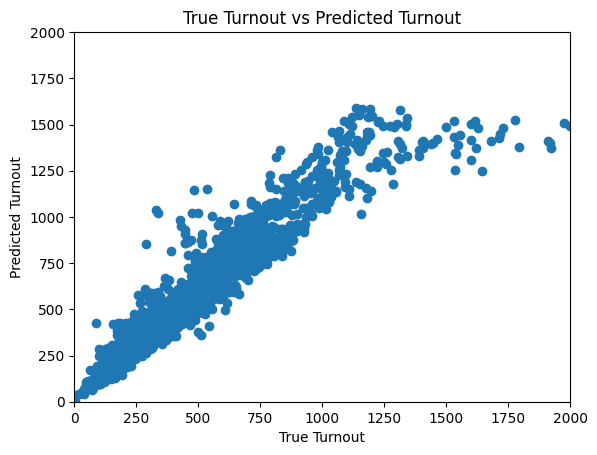

In [221]:
# Plot Turnout vs Predicted Turnout for y_test

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('True Turnout')
plt.ylabel('Predicted Turnout')
plt.title('True Turnout vs Predicted Turnout')

plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.show()

Looks like there is some heteroskedasticity in the residuals - as our turnout goes past 1500, the predictions are too conservative. That can be explainable by the huge spike in turnouts in 2020, which would be more congregated in precincts with higher populations.



Now that we have a model, we need all of our features for 2026. That means calculating the demographic features for race, income, and disability, per precinct. Because this is a "thin" dataset, where we effectively only have a few years for each precinct, this won't be too statistically robust.

One thing I want to point out - we are using demographic data to predict voter turnout. However, we are not saying the demographic data predicted makes up the voting base - it simply makes up the populace of the precinct.

In [127]:
data.columns

Index(['district', 'registered_voters', 'ballots_cast', 'voter_turnout',
       'year', 'is_midterm', 'name', 'type', 'label', 'district_1', 'ward_1',
       'municode_1', 'mwd_nopa_1', 'opa_muni_1', 'mwd_pad_1', 'pseud4_12',
       'pseudonu_5', 'muni_war_1', 'race_percent_white', 'race_percent_black',
       'race_percent_native', 'race_percent_asian',
       'race_percent_pacific_islander', 'race_percent_hispanic',
       'race_percent_other', 'income_percent_below_15K',
       'income_percent_15K_35K', 'income_percent_35K_65K',
       'income_percent_above_65K', 'total', 'male_percent', 'female_percent',
       'disability_percent', 'male_disability_percent',
       'female_disability_percent', 'tracts', 'lagged_turnout',
       'lagged_percentage_turnout'],
      dtype='object')

In [241]:
data_2026 = []

columns_to_predict = ['race_percent_white', 'race_percent_black',
       'race_percent_native', 'race_percent_asian',
       'race_percent_pacific_islander', 'race_percent_hispanic',
       'race_percent_other', 'income_percent_below_15K',
       'income_percent_15K_35K', 'income_percent_35K_65K',
       'income_percent_above_65K', 'male_percent', 'female_percent',
       'disability_percent', 'male_disability_percent',
       'female_disability_percent']

for district in data['district'].unique():
    district_data = data.loc[data['district'] == district].reset_index().copy()[columns_to_predict + ['total']]
    district_df = {}
    # First, predict total turnout
    X = district_data.index.values.reshape(-1, 1)
    y = district_data['total'].values.reshape(-1, 1)
    y_pred = LinearRegression().fit(X, y).predict((max(X) + 2).reshape(-1, 1))
    district_df['total'] = y_pred[0][0]

    for column in columns_to_predict:
        # Make a simple y = mx + b prediction
        curr_col = district_data[column] * district_data['total']
        X = curr_col.index.values.reshape(-1, 1)
        y = curr_col.values.reshape(-1, 1)
        y_pred = LinearRegression().fit(X, y).predict((max(X) + 2).reshape(-1, 1))
        district_df[column] = y_pred[0][0] / district_df['total']

    district_df['district'] = district
    data_2026.append(district_df)

data_2026 = pd.DataFrame(data_2026)

In [251]:
precinct_2024 = pd.read_csv('total_precincts.csv').drop(columns=['Unnamed: 0'])
precinct_2024 = precinct_2024[precinct_2024['year'] == 2024].reset_index(drop=True).copy()

new_df = pd.DataFrame()
new_df['district'] = precinct_2024['district']
new_df['year'] = 2026
new_df['is_midterm'] = 1
new_df['lagged_turnout'] = precinct_2024['ballots_cast']
new_df['lagged_percentage_turnout'] = precinct_2024['voter_turnout']

In [254]:
data_2026 = data_2026.merge(new_df, on='district', how='left')
data_2026

,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,race_percent_other,income_percent_below_15K,income_percent_15K_35K,...,male_percent,female_percent,disability_percent,male_disability_percent,female_disability_percent,district,year,is_midterm,lagged_turnout,lagged_percentage_turnout
0,3587.021486,0.924896,0.003024,5.720420e-03,0.010605,-2.633684e-07,0.028436,0.004876,0.146698,0.227556,...,0.472122,0.527878,0.209212,0.089035,0.120178,ALEPPO,2026,1,1128,82.76
1,2819.197463,0.741135,0.065131,1.319492e-07,0.182826,0.000000e+00,0.004830,0.002541,0.056678,0.066834,...,0.417552,0.580313,0.100020,0.015977,0.084043,ASPINWALL DIST 1,2026,1,730,85.38
2,2830.095799,0.743008,0.065388,-7.110469e-06,0.182487,0.000000e+00,0.004958,0.002505,0.057540,0.067789,...,0.419150,0.580850,0.100290,0.016164,0.084126,ASPINWALL DIST 2,2026,1,472,81.10
3,2831.447923,0.743035,0.065403,-8.485587e-06,0.182351,0.000000e+00,0.004980,0.002494,0.057671,0.067945,...,0.419255,0.580708,0.100306,0.016192,0.084114,ASPINWALL DIST 3,2026,1,698,84.40
4,2203.983574,0.713338,0.229701,2.699011e-03,0.003748,0.000000e+00,0.026200,0.009296,0.178168,0.297448,...,0.605259,0.394741,0.234994,0.151556,0.083438,AVALON WARD 1,2026,1,849,76.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,1480.000000,0.222341,0.710557,0.000000e+00,-0.037573,1.000000e-03,0.092573,0.020546,0.423703,0.165827,...,0.431081,0.568919,0.286486,0.065541,0.220946,PITTSBURGH WARD 12 DIST 2,2026,1,153,50.50
1128,1809.711974,0.093957,0.840640,-1.455093e-02,-0.000042,8.728051e-07,-0.007185,0.099325,0.031905,0.607462,...,0.472320,0.527680,0.177457,-0.007663,0.185119,PITTSBURGH WARD 12 DIST 9,2026,1,138,48.25
1129,3307.068654,0.374426,0.344919,4.739217e-03,0.021817,0.000000e+00,-0.005187,0.000012,0.146051,0.083124,...,0.558772,0.441228,0.176877,0.132123,0.044753,PITTSBURGH WARD 21 DIST 3,2026,1,402,66.12
1130,3469.000000,0.685764,0.240840,2.710061e-02,-0.020456,0.000000e+00,0.000799,0.029101,0.139538,0.159396,...,0.464975,0.535025,0.127703,0.084462,0.043240,PITTSBURGH WARD 22 DIST 2,2026,1,487,72.58


In [ ]:
X = data_2026[['is_midterm', 'lagged_turnout', 'year', 'total',
          'race_percent_white', 'race_percent_black',
          'race_percent_native', 'race_percent_asian',
          'race_percent_pacific_islander', 'race_percent_hispanic',
          'race_percent_other', 'income_percent_below_15K',
          'income_percent_15K_35K', 'income_percent_35K_65K',
          'income_percent_above_65K', 'male_percent', 'female_percent',
          'disability_percent', 'male_disability_percent',
          'female_disability_percent'
        ]].copy()

X['able_bodied_percent'] = 1 - X['disability_percent']

income_columns = ['income_percent_below_15K',
                  'income_percent_15K_35K',
                  'income_percent_35K_65K',
                  'income_percent_above_65K']

race_columns = ['race_percent_white',
                'race_percent_black',
                'race_percent_native',
                'race_percent_asian',
                'race_percent_pacific_islander',
                'race_percent_hispanic',
                'race_percent_other']

disability_columns = ['disability_percent', 'able_bodied_percent']

gender_columns = ['male_percent', 'female_percent']

for income_column in income_columns:
  for race_column in race_columns:
    for disability_column in disability_columns:
      for gender_column in gender_columns:
        X[income_column + ' * ' + race_column + ' * ' + disability_column + ' * ' + gender_column] = X[income_column] *\
                                                                                                     X[race_column] *\
                                                                                                     X[disability_column] *\
                                                                                                     X[gender_column] 

for income_column in income_columns:
  for race_column in race_columns:
    for disability_column in disability_columns:
      X[income_column + ' * ' + race_column + ' * ' + disability_column] = X[income_column] * X[race_column] * X[disability_column]

for income_column in income_columns:
  for race_column in race_columns:
    for gender_column in gender_columns:
      X[income_column + ' * ' + race_column + ' * ' + gender_column] = X[income_column] * X[race_column] * X[gender_column]

for race_column in race_columns:
  for disability_column in disability_columns:
    for gender_column in gender_columns:
      X[race_column + ' * ' + disability_column + ' * ' + gender_column] = X[race_column] * X[disability_column] * X[gender_column]

for income_column in income_columns:
  for race_column in race_columns:
    X[income_column + ' * ' + race_column] = X[income_column] * X[race_column]

for income_column in income_columns:
  for disability_column in disability_columns:
    X[income_column + ' * ' + disability_column] = X[income_column] * X[disability_column]

for income_column in income_columns:
  for gender_column in gender_columns:
    X[income_column + ' * ' + gender_column] = X[income_column] * X[gender_column]

for disability_column in disability_columns:
  for race_column in race_columns:
    X[disability_column + ' * ' + race_column] = X[disability_column] * X[race_column]

for disability_column in disability_columns:
  for gender_column in gender_columns:
    X[disability_column + ' * ' + gender_column] = X[disability_column] * X[gender_column]

for race_column in race_columns:
  for gender_column in gender_columns:
    X[race_column + ' * ' + gender_column] = X[race_column] * X[gender_column]

X_dropped = X.drop(columns=['is_midterm', 'lagged_turnout', 'year', 'total'])
X_cols = X_dropped.columns

/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipykernel_5171/2671085980.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[income_column + ' * ' + race_column + ' * ' + disability_column + ' * ' + gender_column] = X[income_column] *\
/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipykernel_5171/2671085980.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[income_column + ' * ' + race_column + ' * ' + disability_column + ' * ' + gender_column] = X[income_column] *\
/var/folders/73/yf0vhxc16_s7l4d4j28m32bh0000gn/T/ipy

In [257]:
columns = ['is_midterm', 'lagged_turnout', 'year', 'total']
X_selected = X[selected_features + columns].copy()

In [260]:
y_pred = model.predict(X_selected)
data_2026['ballots_cast'] = y_pred.astype(int)

In [261]:
data_2026

,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,race_percent_other,income_percent_below_15K,income_percent_15K_35K,...,female_percent,disability_percent,male_disability_percent,female_disability_percent,district,year,is_midterm,lagged_turnout,lagged_percentage_turnout,ballots_cast
0,3587.021486,0.924896,0.003024,5.720420e-03,0.010605,-2.633684e-07,0.028436,0.004876,0.146698,0.227556,...,0.527878,0.209212,0.089035,0.120178,ALEPPO,2026,1,1128,82.76,1127
1,2819.197463,0.741135,0.065131,1.319492e-07,0.182826,0.000000e+00,0.004830,0.002541,0.056678,0.066834,...,0.580313,0.100020,0.015977,0.084043,ASPINWALL DIST 1,2026,1,730,85.38,629
2,2830.095799,0.743008,0.065388,-7.110469e-06,0.182487,0.000000e+00,0.004958,0.002505,0.057540,0.067789,...,0.580850,0.100290,0.016164,0.084126,ASPINWALL DIST 2,2026,1,472,81.10,427
3,2831.447923,0.743035,0.065403,-8.485587e-06,0.182351,0.000000e+00,0.004980,0.002494,0.057671,0.067945,...,0.580708,0.100306,0.016192,0.084114,ASPINWALL DIST 3,2026,1,698,84.40,618
4,2203.983574,0.713338,0.229701,2.699011e-03,0.003748,0.000000e+00,0.026200,0.009296,0.178168,0.297448,...,0.394741,0.234994,0.151556,0.083438,AVALON WARD 1,2026,1,849,76.14,707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,1480.000000,0.222341,0.710557,0.000000e+00,-0.037573,1.000000e-03,0.092573,0.020546,0.423703,0.165827,...,0.568919,0.286486,0.065541,0.220946,PITTSBURGH WARD 12 DIST 2,2026,1,153,50.50,99
1128,1809.711974,0.093957,0.840640,-1.455093e-02,-0.000042,8.728051e-07,-0.007185,0.099325,0.031905,0.607462,...,0.527680,0.177457,-0.007663,0.185119,PITTSBURGH WARD 12 DIST 9,2026,1,138,48.25,97
1129,3307.068654,0.374426,0.344919,4.739217e-03,0.021817,0.000000e+00,-0.005187,0.000012,0.146051,0.083124,...,0.441228,0.176877,0.132123,0.044753,PITTSBURGH WARD 21 DIST 3,2026,1,402,66.12,336
1130,3469.000000,0.685764,0.240840,2.710061e-02,-0.020456,0.000000e+00,0.000799,0.029101,0.139538,0.159396,...,0.535025,0.127703,0.084462,0.043240,PITTSBURGH WARD 22 DIST 2,2026,1,487,72.58,428
